In [ ]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,990 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [80.6 kB]
Hit:14 http://ppa.launchpad.n

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/MDS0_k278_VuThiHa/Cau_3/'

/content/gdrive/MyDrive/MDS0_k278_PhamCaoSang/Cong_viec_03_RNN_LSTM


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType,BooleanType,DateType

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, VectorAssembler, HashingTF
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline

In [ ]:
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession(sc)

In [ ]:
df = spark.read.csv("process_data.csv", inferSchema = True, header = True, sep = ',')
df.show(2)

+---+--------------------+------+---------+------+--------------------+
|_c0|                text|rating|sentiment|output|      processed_text|
+---+--------------------+------+---------+------+--------------------+
|  0|Quá Tuyệt Vời Khi...|     5| Positive|     1|tuyệt_vời trải_ng...|
|  1|Đáng đồng tiền!. ...|     5| Positive|     1|đồng_tiền chuyên_...|
+---+--------------------+------+---------+------+--------------------+
only showing top 2 rows



In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- output: string (nullable = true)
 |-- processed_text: string (nullable = true)



In [ ]:
df = df.withColumn("rating", df.rating.cast(IntegerType()))
df = df.withColumn("output", df.output.cast(IntegerType()))
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- output: integer (nullable = true)
 |-- processed_text: string (nullable = true)



In [ ]:
df = df.na.drop()

In [ ]:
df = df.select(['processed_text', 'output'])

In [ ]:
steps = []
steps.extend([
    RegexTokenizer(
        inputCol = "processed_text",
        outputCol = "token_text",
        pattern = "\s"
    ),
    CountVectorizer(
        inputCol = "token_text",
        outputCol = "countV_text"
    ),
    IDF(
        inputCol = "countV_text",
        outputCol = "idf_text"
    )
])
    
steps.append(
    VectorAssembler(
        inputCols = ["idf_text"],
        outputCol = "features"
    )
)
    

In [ ]:
pipeline = Pipeline(
    stages = steps
)
data_final = pipeline.fit(df).transform(df)

In [ ]:
data_final.select("features").show(3, truncate = 150)

+------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                              features|
+------------------------------------------------------------------------------------------------------------------------------------------------------+
|(16944,[1,2,6,7,41,46,54,64,69,73,96,108,116,120,138,159,171,191,223,267,462,515,541,913,1238,1326,1550,2145,2949,3186,6008,16341],[3.1388554359800...|
|(16944,[21,67,95,185,200,208,418,453],[2.9158464050047286,3.6872672661260983,3.964020268045689,4.491228813026334,4.641480852437935,4.70161921117646...|
|(16944,[1,3,5,10,24,31,39,44,46,56,82,118,130,133,145,159,172,183,193,209,214,243,427,429,535,572,617,825,870,996,1028,1053,1666,1836,4719,7940,111...|
+---------------------------------------------------------------------------------

In [ ]:
train, test = data_final.randomSplit([0.85, 0.15])

# Naive Bayes model

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
nb = NaiveBayes(featuresCol='features', labelCol='output')
nbModel = nb.fit(train)
nb_test_results = nbModel.transform(test)

In [ ]:
eval = MulticlassClassificationEvaluator(labelCol='output')
nb_test_acc = eval.evaluate(nb_test_results)
nb_test_acc

0.9067904801164384

In [ ]:
nb_test_results.show(10)

+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|      processed_text|output|          token_text|         countV_text|            idf_text|            features|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|acccomdating tốt ...|     1|[acccomdating, tố...|(16944,[0,1,11,11...|(16944,[0,1,11,11...|(16944,[0,1,11,11...|[-169.14681756725...|[0.99904695254189...|       0.0|
|are thân_thiện nh...|     0|[are, thân_thiện,...|(16944,[0,3,6,42,...|(16944,[0,3,6,42,...|(16944,[0,3,6,42,...|[-848.04899345974...|[1.0,1.7735520748...|       0.0|
|bathroom swiming ...|     1|[bathroom, swimin...|(16944,[22,35,471...|(16944,[22,35,471...|(16944,[22,35,471...|[-558.71023210375...|[0.96000882473276...|       0.0

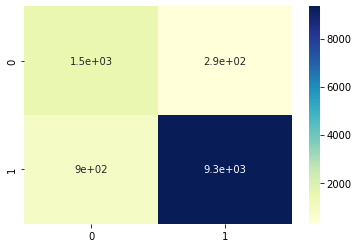

In [ ]:
matrix = confusion_matrix(y_true = nb_test_results.select('output').toPandas(), y_pred = nb_test_results.select('prediction').toPandas(), labels = [0, 1] )
sns.heatmap(matrix, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
plt.show()

In [ ]:
print(classification_report(y_true = nb_test_results.select('output').toPandas(), y_pred = nb_test_results.select('prediction').toPandas(), labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.63      0.84      0.72      1838
           1       0.97      0.91      0.94     10242

    accuracy                           0.90     12080
   macro avg       0.80      0.88      0.83     12080
weighted avg       0.92      0.90      0.91     12080



# Logistic Classifier

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='output')
lrModel = lr.fit(train)
lr_test_results = lrModel.transform(test)

In [ ]:
eval = MulticlassClassificationEvaluator(labelCol='output')
lr_test_acc = eval.evaluate(lr_test_results)
lr_test_acc

0.9103304400403974

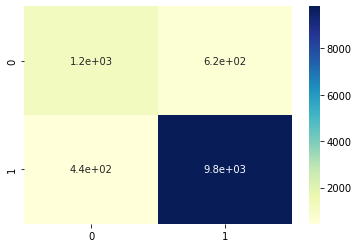

In [ ]:
matrix = confusion_matrix(y_true = lr_test_results.select('output').toPandas(), y_pred = lr_test_results.select('prediction').toPandas(), labels = [0, 1] )
sns.heatmap(matrix, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
plt.show()

In [ ]:
print(classification_report(y_true = lr_test_results.select('output').toPandas(), y_pred = lr_test_results.select('prediction').toPandas(), labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1838
           1       0.94      0.96      0.95     10242

    accuracy                           0.91     12080
   macro avg       0.84      0.81      0.82     12080
weighted avg       0.91      0.91      0.91     12080



# GBT

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
gbt = GBTClassifier(featuresCol='features', labelCol='output')
gbtModel = gbt.fit(train)
gbt_test_results = gbtModel.transform(test)

In [ ]:
eval = MulticlassClassificationEvaluator(labelCol='output')
rf_test_acc = eval.evaluate(gbt_test_results)
rf_test_acc

0.8750806449404577

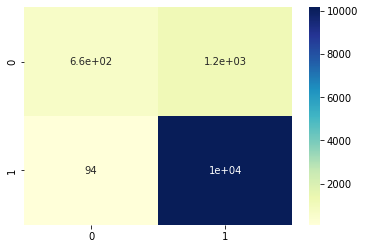

In [ ]:
matrix = confusion_matrix(y_true = gbt_test_results.select('output').toPandas(), y_pred = gbt_test_results.select('prediction').toPandas(), labels = [0, 1] )
sns.heatmap(matrix, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
plt.show()

In [ ]:
print(classification_report(y_true = gbt_test_results.select('output').toPandas(), y_pred = gbt_test_results.select('prediction').toPandas(), labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.88      0.36      0.51      1838
           1       0.90      0.99      0.94     10242

    accuracy                           0.89     12080
   macro avg       0.89      0.67      0.72     12080
weighted avg       0.89      0.89      0.88     12080



#Multi layer perceptron

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
# specify layers for the neural network:
# input layer of size 1 (features), two intermediate of size 5 and 4
# and output of size 2 (classes)
layers = [1, 5, 4, 2]

In [ ]:
pct = MultilayerPerceptronClassifier(featuresCol='features', labelCol='output', layers=layers)
pctModel = gbt.fit(train)
pct_test_results = pctModel.transform(test)

In [ ]:
eval = MulticlassClassificationEvaluator(labelCol='output')
pct_test_acc = eval.evaluate(pct_test_results)
pct_test_acc

0.8750806449404577

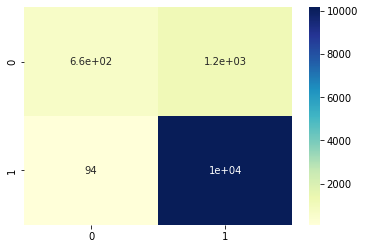

In [ ]:
matrix = confusion_matrix(y_true = pct_test_results.select('output').toPandas(), y_pred = pct_test_results.select('prediction').toPandas(), labels = [0, 1] )
sns.heatmap(matrix, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
plt.show()

In [ ]:
print(classification_report(y_true = pct_test_results.select('output').toPandas(), y_pred = pct_test_results.select('prediction').toPandas(), labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.88      0.36      0.51      1838
           1       0.90      0.99      0.94     10242

    accuracy                           0.89     12080
   macro avg       0.89      0.67      0.72     12080
weighted avg       0.89      0.89      0.88     12080

